In [22]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import random


# import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, auc, roc_curve, precision_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", UserWarning)
simplefilter("ignore", category= FitFailedWarning)

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

pd.options.mode.chained_assignment = None  
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 50) 

## Functions

In [23]:
# 1. Fun
def encode_and_bind(original_dataframe, feature_to_encode):

    """
    This function makes One-hot-encoding
    Input: 
    - original dataset
    - feature for One-hot-encoding
    Output:
    - datatable with One-hot-encoded features
    
    """
    #1. Make dummies and OHE     
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1).drop(feature_to_encode, axis=1)
    
    return(res)

In [24]:
# 4. Fun
def feature_description(feature, data):
    sns.set(
    font_scale =0.7,
    style      ="whitegrid",
    )
    print('Analyzed feature: ',feature)
    
    if feature in cat_col:
        fig, axes = plt.subplots(2, 1, figsize=(5, 7))

                
        fig1 = sns.countplot(ax=axes[0], data=data, y= feature, orient='h')
        fig1.set(xlabel=None, ylabel = None) 
        axes[0].set_title(f'Distribution of {feature}')
        
        fig2 = sns.barplot(ax=axes[1],y=feature, x="bad_client_target",  data=data, orient='h', errorbar=None)
        fig2.set(xlabel=None, ylabel = None) 
        axes[1].set_title(f'Normalised ratio of bad clients with respect to {feature}')
        
        fig.tight_layout()
        
    if feature in num_col:
        fig, axes = plt.subplots(2, 1, figsize=(5, 7))

                
        fig1 = sns.histplot(ax=axes[0], data=data, x= feature);
        fig1.set(xlabel=None, ylabel = None) 
        axes[0].set_title(f'Distribution of {feature}')
        
        fig2 = sns.boxplot(ax=axes[1],x=feature, y="bad_client_target",  data=data, orient='h') ;
        fig2.set(xlabel=None, ylabel = None) 
        axes[1].set_title(f'Distribution of client types by {feature}')
        
        fig.tight_layout()    

In [25]:
def rfe_selector(X, y, num_feats):
    # 1. Create the object and fit
    model = RandomForestClassifier(random_state=5, 
                               max_depth = 4,
                               max_features = 3,
                               n_estimators = 1000
                              )

    rfe_lr = RFE(estimator=model, 
                 n_features_to_select=num_feats,
                 step=1,
                 verbose=0
    )
    rfe_lr = rfe_lr.fit(X, y)

    # 2. Get Support from the model
    rfe_support = rfe_lr.get_support()

    # 3. Best features from the model
    rfe_feature = X.loc[:, rfe_support].columns.tolist()
    # rfe_lr_feature
    return rfe_support, rfe_feature

## Download data

DataSource:
https://www.kaggle.com/datasets/podsyp/is-this-a-good-customer

In [5]:
# 1. Set path and download data 
data = pd.read_csv(Path('..//data//clients.csv'), sep=',' )

print('data shape:',data.shape)
data.head()

data shape: (1723, 14)


,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


## Data description

In [6]:
# 1. Look at main info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 188.6+ KB


In [7]:
# 2. Split data on numerical and categorical var
num_col = [ 'credit_amount', 'credit_term', 'age',
          'income'
          ]
cat_col = [ 'month','sex', 'education', 'product_type', 
           'family_status', 'having_children_flg', 'region', 
           'phone_operator', 'is_client', 'bad_client_target'
          ]
all_columns = data.columns

In [8]:
# 2.1 Description of numerical vars
data[num_col].describe()

,credit_amount,credit_term,age,income
count,1723.000000,1723.000000,1723.000000,1723.000000
mean,29264.654672,11.546721,35.911782,32652.350551
std,27926.778301,6.548354,13.120203,20913.193158
min,5000.000000,3.000000,18.000000,1000.000000
25%,13000.000000,6.000000,26.000000,21000.000000
50%,21500.000000,12.000000,32.000000,27000.000000
75%,34000.000000,12.000000,44.000000,38000.000000
max,301000.000000,36.000000,90.000000,401000.000000


In [9]:
# 2.2 Description cat variables
(data[cat_col]
 .astype({'having_children_flg': 'object',
          'region': 'object',
          'phone_operator': 'object',
          'is_client': 'object',
          'bad_client_target': 'object',
          'month': 'object',
         })
 .describe()
)

,month,sex,education,product_type,family_status,having_children_flg,region,phone_operator,is_client,bad_client_target
count,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723
unique,12,2,6,22,3,2,3,5,2,2
top,11,male,Secondary special education,Cell phones,Another,0,2,1,1,0
freq,174,931,836,498,1201,985,1414,666,1042,1527


In [10]:
# 3. Checking NA values
data.isna().sum()

month                  0
credit_amount          0
credit_term            0
age                    0
sex                    0
education              0
product_type           0
having_children_flg    0
region                 0
income                 0
family_status          0
phone_operator         0
is_client              0
bad_client_target      0
dtype: int64

In [11]:
# Conclusion:
# 1. No NA values

### Insights of the dependent variable

In [12]:
# 1. Determine general params for a plot
sns.set(
    font_scale =1,
    style      ="whitegrid",
)


Statistics
0    1527
1     196
Name: bad_client_target, dtype: int64
0    0.886245
1    0.113755
Name: bad_client_target, dtype: float64


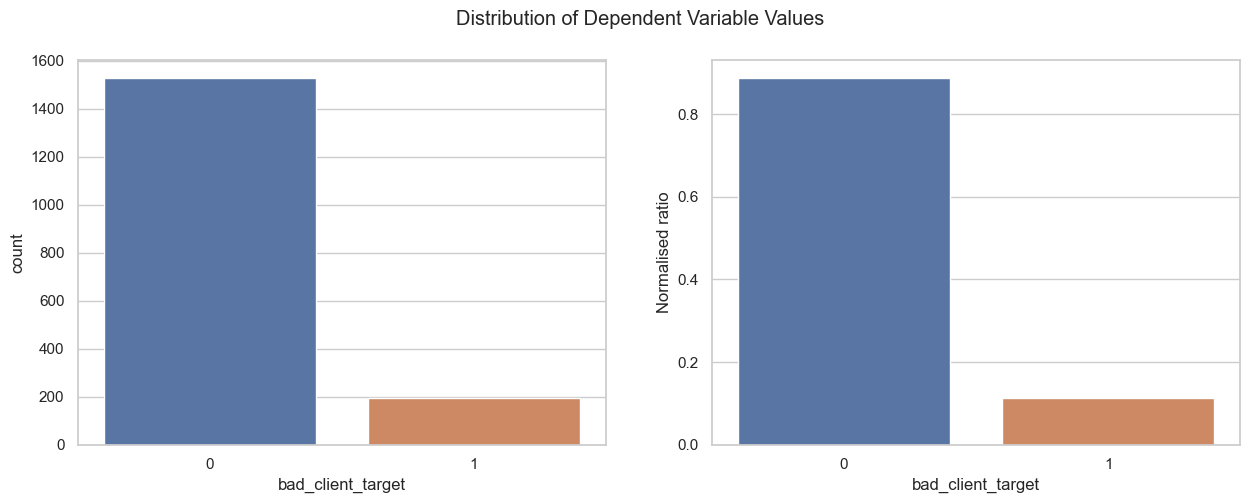

In [15]:
# 1. Plot distribution of dependant variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Distribution of Dependent Variable Values')
fig1 = sns.countplot(ax=axes[0], data=data, x='bad_client_target', orient='v');
df_share = pd.DataFrame(data.bad_client_target.value_counts(1)).reset_index()
df_share.columns = ['bad_client_target', 'Normalised ratio']
fig2 =sns.barplot(data=df_share, x='bad_client_target', y='Normalised ratio');

print()
print('Statistics')
print(data.bad_client_target.value_counts())
print(data.bad_client_target.value_counts(1))

In [14]:
# Conclusion:
# This is an imbalanced dataset'

### Insights of the independent variables

#### month

Analyzed feature:  month


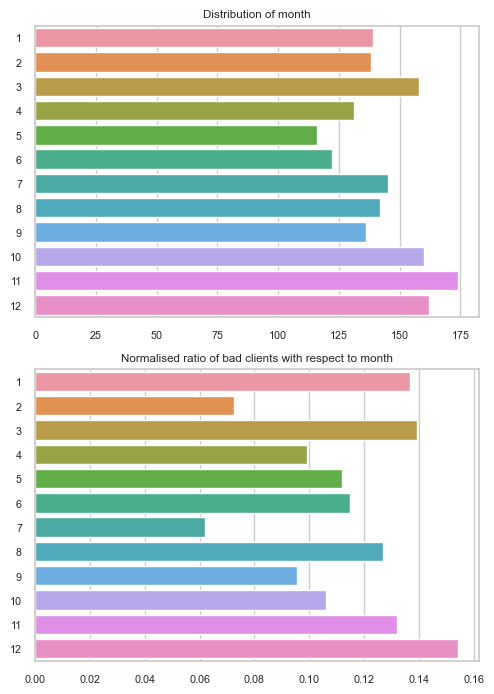

In [26]:
feature = data.columns[0]
feature_description(feature, data)

#### credit_amount

Analyzed feature:  credit_amount


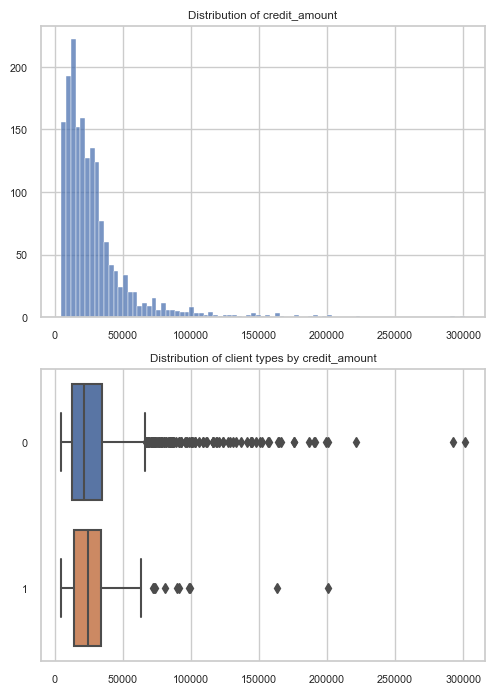

In [16]:
feature = data.columns[1]
feature_description(feature, data)

#### credit_term

Analyzed feature:  credit_term


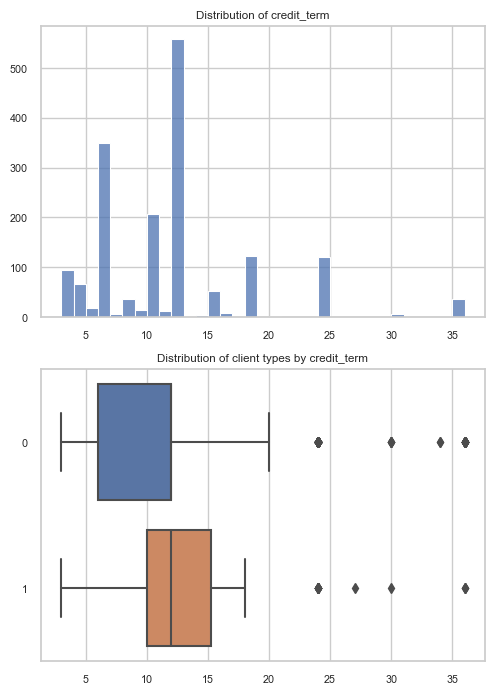

In [17]:
feature = data.columns[2]
feature_description(feature, data)

#### age

Analyzed feature:  age


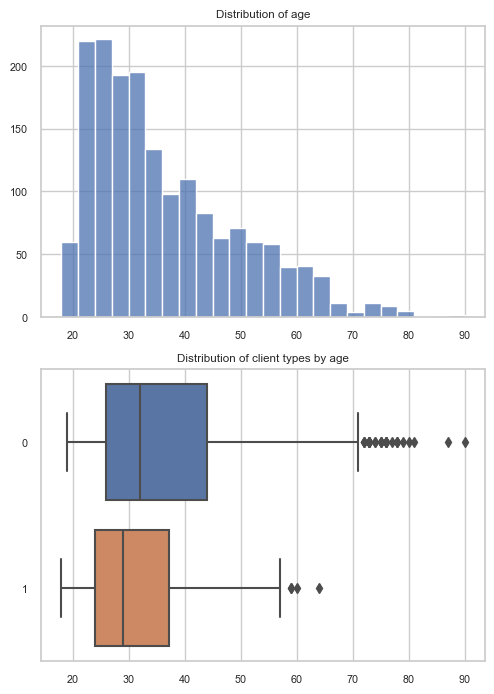

In [18]:
feature = data.columns[3]
feature_description(feature, data)

#### sex

Analyzed feature:  sex


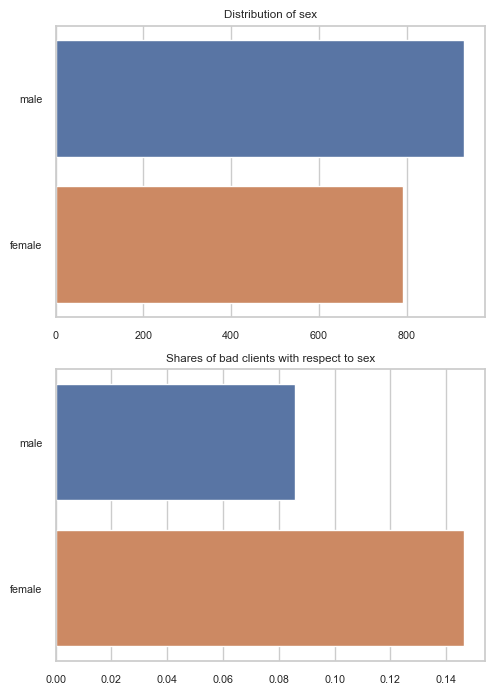

In [19]:
feature = data.columns[4]
feature_description(feature, data)

#### education

Analyzed feature:  education


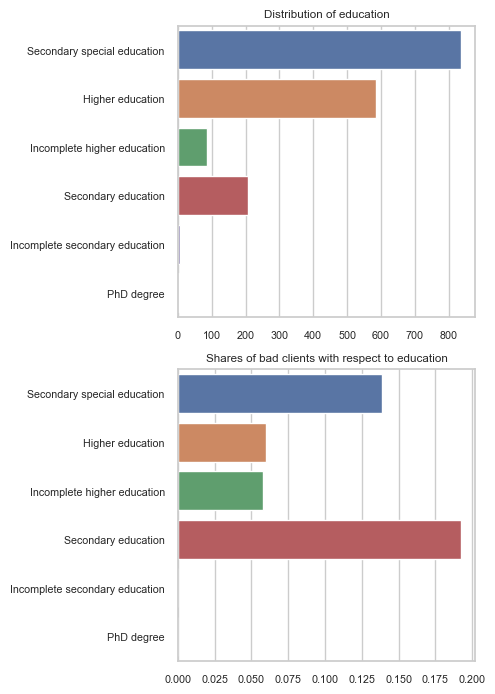

In [20]:
feature = data.columns[5]
feature_description(feature, data)

#### product_type

Analyzed feature:  product_type


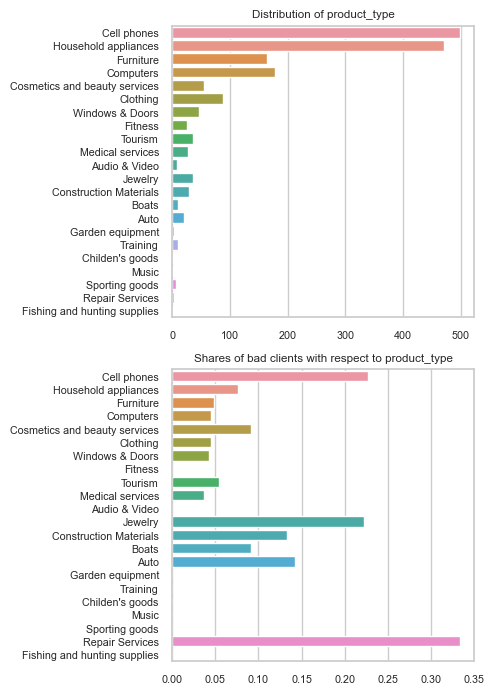

In [21]:
feature = data.columns[6]
feature_description(feature, data)

#### having_children_flg

Analyzed feature:  having_children_flg


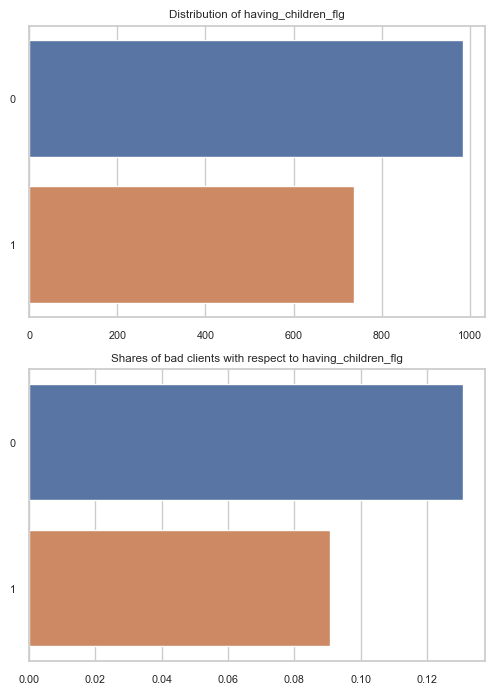

In [22]:
feature = data.columns[7]
feature_description(feature, data)

#### region

Analyzed feature:  region


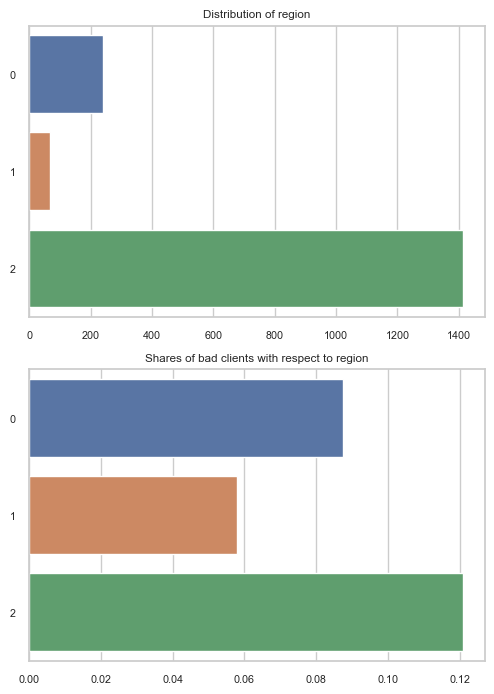

In [23]:
feature = data.columns[8]
feature_description(feature, data)

#### income

Analyzed feature:  income


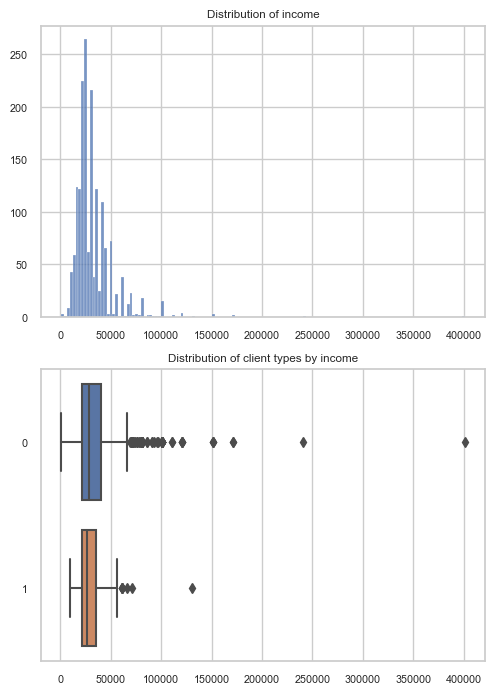

In [24]:
feature = data.columns[9]
feature_description(feature, data)

#### family_status

Analyzed feature:  family_status


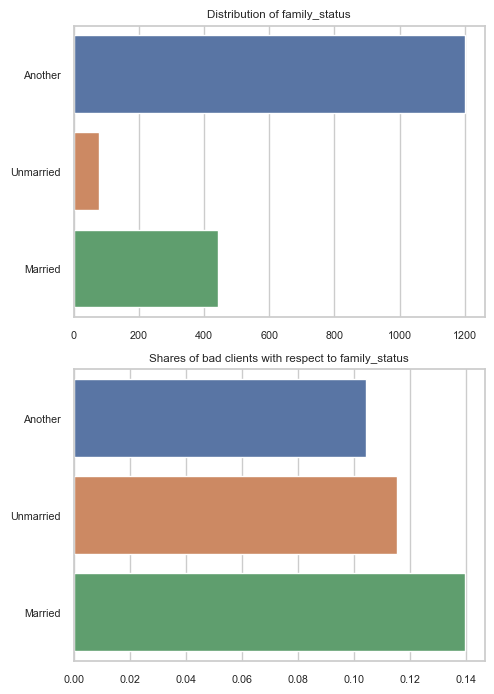

In [25]:
feature = data.columns[10]
feature_description(feature, data)

#### phone_operator

Analyzed feature:  phone_operator


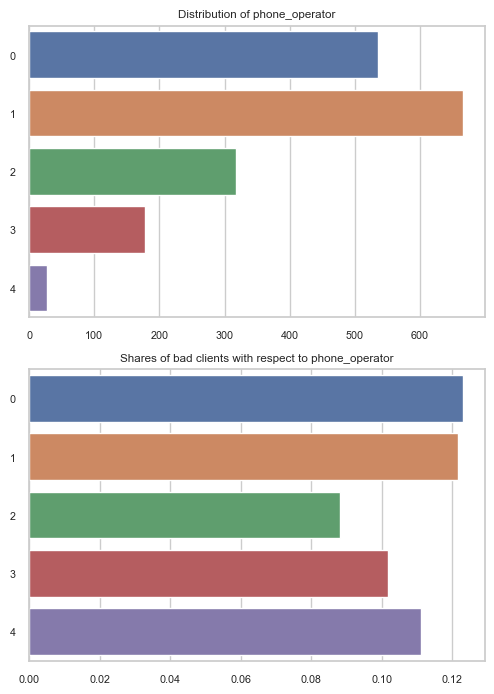

In [26]:
feature = data.columns[11]
feature_description(feature, data)

#### is_client

Analyzed feature:  is_client


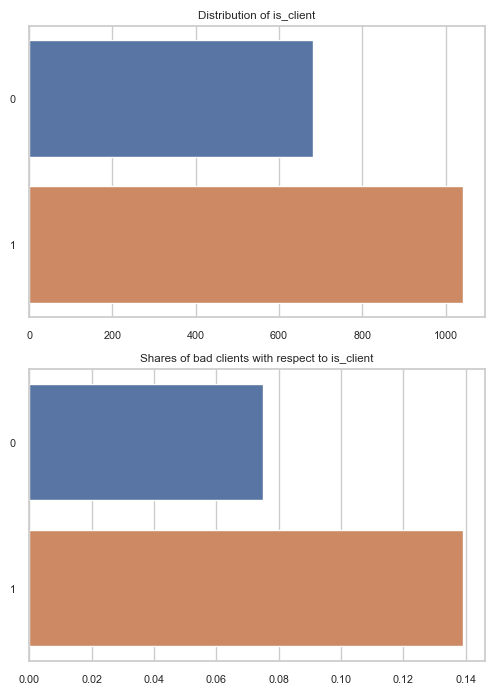

In [27]:
feature = data.columns[12]
feature_description(feature, data)

In [28]:
# Conclusions:

# 1. Most bad clients are in December, minority are in July.
# 2. There are outliers in credit amount.
# 3. Bad clients have higher credit term.
# 4. Female are bad clients more frequently.
# 5. People with only secondary education are bad clients more frequently.
# 6. It seems that loan for cell phone is the most risky
# 7. People with children are less risky clients
# 8. People from region 3 are riskier.
# 9. There are outliers in income.
# 10. Marriage status, phone operator don’t influence the probability of client default
# 11. Clients of bank are more risky 

## Data preprocessing

### One-hot-encoding

In [29]:
# OHE
ohe_vars = ['education', 'product_type', 'family_status', 'sex']

print('Before: ',data.shape)
for ohe_var in ohe_vars:
    data = encode_and_bind(data , ohe_var)
    
data = data.drop('sex_male', axis = 1)
data = data.rename(columns = {"product_type_Childen's goods": "product_type_Childen_good"})
print('After: ',data.shape)    

Before:  (1723, 14)
After:  (1723, 42)


In [30]:
# Swap data
data = data[['bad_client_target','month', 'credit_amount', 
      'credit_term', 'age', 'having_children_flg',
       'region', 'income', 'phone_operator', 'is_client', 
       'education_Higher education', 'education_Incomplete higher education',
       'education_Incomplete secondary education', 'education_PhD degree',
       'education_Secondary education',
       'education_Secondary special education', 'product_type_Audio & Video',
       'product_type_Auto', 'product_type_Boats', 'product_type_Cell phones',
       'product_type_Childen_good', 'product_type_Clothing',
       'product_type_Computers', 'product_type_Construction Materials',
       'product_type_Cosmetics and beauty services',
       'product_type_Fishing and hunting supplies', 'product_type_Fitness',
       'product_type_Furniture', 'product_type_Garden equipment',
       'product_type_Household appliances', 'product_type_Jewelry',
       'product_type_Medical services', 'product_type_Music',
       'product_type_Repair Services', 'product_type_Sporting goods',
       'product_type_Tourism', 'product_type_Training',
       'product_type_Windows & Doors', 'family_status_Another',
       'family_status_Married', 'family_status_Unmarried', 'sex_female']]

## Modelling

### Train and test split

In [31]:
# split data to features and label
X = data.iloc[:,1:]
y = data.bad_client_target


# split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=5);
print(X_train.shape)
print(X_test.shape)


(1206, 41)
(517, 41)


In [32]:
print('y distribution - train: \n',y_train.value_counts())
print()
print('y distribution - test: \n',y_test.value_counts())

y distribution - train: 
 0    1073
1     133
Name: bad_client_target, dtype: int64

y distribution - test: 
 0    454
1     63
Name: bad_client_target, dtype: int64


### Default models

In [33]:
# Create result dictionary
res_tab = {}

#### Logistic Regression

In [34]:
# 1. Model name
model_name = 'Logit'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=5))

# 3. Train model
pipeline.fit(X_train,y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.1
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab[model_name] = auc_def

AUC:  0.72764
confusion_matrix: 
 [[287 167]
 [ 16  47]]


#### Decision Tree

In [35]:
# 1. Model name
model_name = 'Decision_Tree'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=5))

# 3. Train model
pipeline.fit(X_train,y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.1
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab[model_name] = auc_def

AUC:  0.5715
confusion_matrix: 
 [[382  72]
 [ 44  19]]


#### Random Forest

In [36]:
# 1. Model name
model_name = 'Random_Forest'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=5))

# 3. Train model
pipeline.fit(X_train,y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.1
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab[model_name] = auc_def

AUC:  0.74953
confusion_matrix: 
 [[270 184]
 [ 14  49]]


#### SGD

In [37]:
# 1. Model name
model_name = 'SGD'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), SGDClassifier(random_state=5))

# 3. Train model
pipeline.fit(X_train,y_train)

# 4. Prediction
prediction = pipeline.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.1
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab[model_name] = auc_def

AUC:  0.49032
confusion_matrix: 
 [[438  16]
 [ 62   1]]


#### SVM

In [38]:
# 1. Model name
model_name = 'SVM'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), SVC(random_state=5, probability=True))

# 3. Train model
pipeline.fit(X_train,y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.1
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab[model_name] = auc_def

AUC:  0.64079
confusion_matrix: 
 [[128 326]
 [  5  58]]


#### Result Table

In [39]:
res_tab_df = (pd.DataFrame.from_dict(res_tab, orient='index')
              .rename(columns = {0:'AUC_default_models'})
              .sort_values('AUC_default_models', ascending = False)
)
res_tab_df

,AUC_default_models
Random_Forest,0.74953
Logit,0.72764
SVM,0.64079
Decision_Tree,0.57150
SGD,0.49032


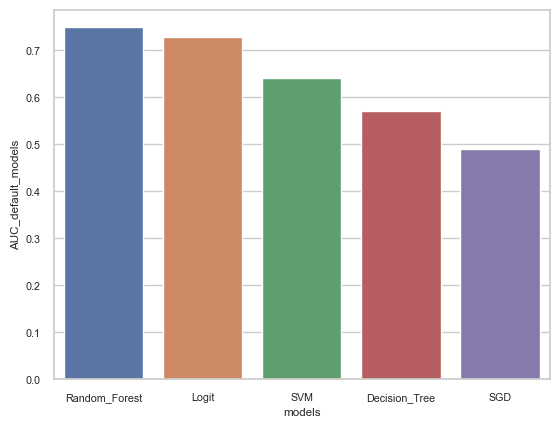

In [41]:
sns.barplot(data=res_tab_df.reset_index().rename(columns = {'index': 'models'}), x='models', y='AUC_default_models')
plt.show()

In [42]:
# The best default model is Random Forest

### Model Tunning

In [43]:
# Create result dictionary for tuned models
res_tab_tuned = {}

#### LogisticRegression

In [44]:
# 1. Model_name
model_name = 'Logit'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), 
                           LogisticRegression(random_state=5)
                        )
# 3. Create the parameter grid
param_grid = [{
    'logisticregression__penalty': ['l2', 'l1', 'elasticnet', None],
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
    'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'logisticregression__tol' : [1e-3, 1e-4]
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_tuned[model_name] = auc_res

GS_best_param:  {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'logisticregression__tol': 0.001}
AUC:  0.74942


#### Decision Tree

In [45]:
# 1. Model_name
model_name = 'Decision_Tree'

# 2. Determine model
scal = StandardScaler()
method = DecisionTreeClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_leaf_nodes': list(range(2, 50, 2)),
    'decisiontreeclassifier__min_samples_split': [2, 3, 5,10],
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_tuned[model_name] = auc_res

GS_best_param:  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_leaf_nodes': 6, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__splitter': 'random'}
AUC:  0.72186


#### Random Forest

In [46]:
# 1. Model_name
model_name = 'Random_Forest'

# 2. Determine model
scal = StandardScaler()
method = RandomForestClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'randomforestclassifier__max_depth': range(2, 10, 2),
    'randomforestclassifier__max_features':[2, 3, 4, 7, 10, None],
    'randomforestclassifier__n_estimators':[10, 50, 100, 500],
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_tuned[model_name] = auc_res

GS_best_param:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 7, 'randomforestclassifier__n_estimators': 100}
AUC:  0.77037


#### SGD

In [47]:
# 1. Model_name
model_name = 'SGD'

# 2. Determine model
scal = StandardScaler()
method = SGDClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'sgdclassifier__alpha':[0.0001, 0.001, 0.01, 0.1],
    'sgdclassifier__loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet', None],
    'sgdclassifier__tol' : [0.001, 0.0001]
    #'sgdclassifier__max_iter':[1000, 10000, 100000]
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_tuned[model_name] = auc_res

GS_best_param:  {'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'modified_huber', 'sgdclassifier__penalty': 'l2', 'sgdclassifier__tol': 0.0001}
AUC:  0.73477


#### SVM

In [48]:
# 1. Model_name
model_name = 'SVM'

# 2. Determine model
scal = StandardScaler()
method = SVC(random_state=5, probability = True)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'svc__C':[0.1, 1, 10, 100, 1000],
    'svc__kernel': ['poly', 'rbf', 'sigmoid'],
    'svc__degree': [3, 4, 5],
    'svc__gamma':[0.1, 0.01, 0.001, 0.0001],
    'svc__tol': [1e-3, 1e-4]
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_tuned[model_name] = auc_res

GS_best_param:  {'svc__C': 1000, 'svc__degree': 3, 'svc__gamma': 0.0001, 'svc__kernel': 'sigmoid', 'svc__tol': 0.001}
AUC:  0.62076


#### Result Table

In [49]:
res_tab_tuned_df = (pd.DataFrame.from_dict(res_tab_tuned, orient='index')
              .rename(columns = {0:'AUC_tuned_models'})
              .sort_values('AUC_tuned_models', ascending = False)
)
res_tab_tuned_df

,AUC_tuned_models
Random_Forest,0.77037
Logit,0.74942
SGD,0.73477
Decision_Tree,0.72186
SVM,0.62076


In [50]:
# Conclusions:
# The best mode is Random Forest, with:
# criterion = gini
# max_depth = 6
# max_features = 7
# n_estimators = 100

#### Default vs Tuned Models

In [51]:
combined_results_df = pd.concat((res_tab_df, res_tab_tuned_df), axis=1)
combined_results_df

,AUC_default_models,AUC_tuned_models
Random_Forest,0.74953,0.77037
Logit,0.72764,0.74942
SVM,0.64079,0.62076
Decision_Tree,0.57150,0.72186
SGD,0.49032,0.73477


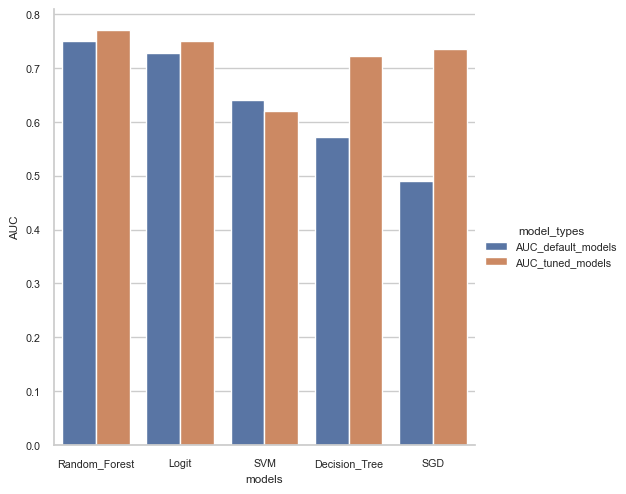

In [53]:
combined_results_df_reshaped = pd.melt(combined_results_df.reset_index().rename(columns = {'index': 'models'}), id_vars='models', var_name='model_types', value_name='AUC')
sns.catplot(data=combined_results_df_reshaped, x='models', y='AUC', hue='model_types', kind='bar')
plt.show()

In [54]:
# Observations:
# All of the models attained better AUC results excetp SVM

In [55]:
# Fit best model
# 1. Fit model
model = RandomForestClassifier(random_state=5,
                               criterion='gini',
                               max_depth = 6,
                               max_features = 7,
                               n_estimators = 100
                              )
pipeline = make_pipeline(StandardScaler(), model)
pipeline.fit(X_train, y_train)

# 2. Prediction
prediction_prob = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)
auc_def = round(auc(fpr, tpr),3)
print('AUC: ', auc_def)

# 3. Prediction + threshold
threshold = 0.15
prediction = np.where(prediction_prob < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

AUC:  0.77
confusion_matrix: 
 [[358  96]
 [ 28  35]]


#### Threshold Analysis

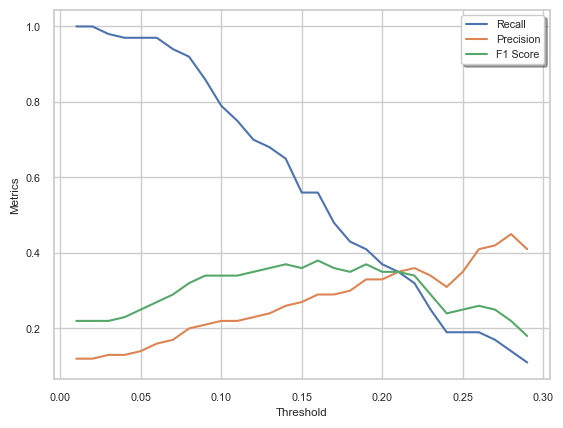

In [56]:
# 1. table with recall, precision, f1 score
rec_prec_threshold = pd.DataFrame(
    {'threshold':np.arange(0.01, 0.3, 0.01),
     'Recall':np.nan,
     'Precision': np.nan,
     'F1_score': np.nan
    } )

# 2. Main calculation
for i in range(len(rec_prec_threshold)):
    prediction = np.where(prediction_prob < rec_prec_threshold['threshold'][i], 0, 1)
    rec_prec_threshold['Recall'][i]  = round(recall_score(y_pred=prediction, y_true=y_test),2)
    rec_prec_threshold['Precision'][i]  = round(precision_score(y_pred=prediction, y_true=y_test),2)
    rec_prec_threshold['F1_score'][i] = round(f1_score(y_pred=prediction, y_true=y_test), 2)

# 3. Plot
x = rec_prec_threshold.threshold
y  = rec_prec_threshold.Recall
z = rec_prec_threshold.Precision
w = rec_prec_threshold.F1_score
plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, w)
plt.legend(['Recall','Precision', 'F1 Score'], shadow = True, loc = 1)
plt.xlabel('Threshold')
plt.ylabel('Metrics');

In [57]:
# Selecting the threshold is a trade-off between Recall and Precision
# Highest f1 score is at threshold = 0.16

### Feature selection

In [60]:
num_feat_auc = {}
for i in tqdm(range(7, X_train.shape[1])):
# for i in [5,15,25,35,41]:
    rfe_support, rfe_feature = rfe_selector(X_train, y_train, num_feats=i)
    
    model = RandomForestClassifier(random_state=5,
                                   criterion='gini',
                                   max_depth = 6,
                                   max_features = 7,
                                   n_estimators = 100,
#                                    n_jobs=-1
                                  )
    model.fit(X_train[rfe_feature],y_train)

    # 2. Prediction
    prediction_prob = model.predict_proba(X_test[rfe_feature])[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)
    auc_def = auc(fpr, tpr)
    
    num_feat_auc[i] = auc_def

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [14:23<00:00, 25.41s/it]


,AUC
number_features,
7,0.722887
8,0.733445
9,0.711768
10,0.719320
11,0.733585
12,0.744983
13,0.736382
14,0.735193
15,0.752954


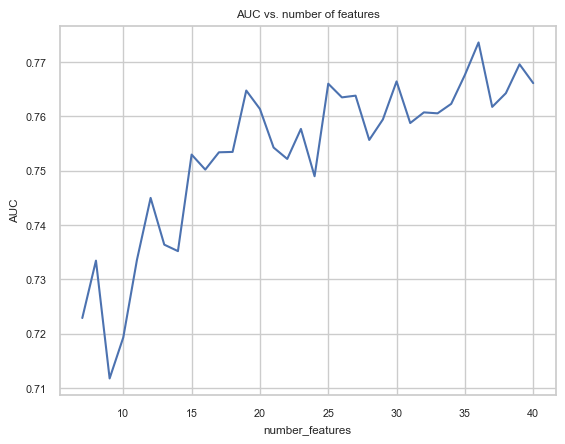

In [63]:
# data for plot
feat_res = \
(pd.DataFrame.from_dict(num_feat_auc, orient='index')
 .rename(columns = {0:'AUC'})
 .reset_index()
 .rename(columns = {'index':'number_features'})
 .set_index('number_features')
)

# Make plot
title = 'AUC vs. number of features'
sns.lineplot(feat_res, x = 'number_features', y = 'AUC').set(title=title);

feat_res

In [96]:
# 36 If we decrease the number of features to 19 the quality of metric will not decrease dramatically
num_feat = 36
rfe_support, rfe_feature = rfe_selector(X_train, y_train, num_feat)
print('selected features', rfe_feature)

selected features ['month', 'credit_amount', 'credit_term', 'age', 'having_children_flg', 'region', 'income', 'phone_operator', 'is_client', 'education_Higher education', 'education_Incomplete higher education', 'education_Incomplete secondary education', 'education_Secondary education', 'education_Secondary special education', 'product_type_Audio & Video', 'product_type_Auto', 'product_type_Boats', 'product_type_Cell phones', 'product_type_Clothing', 'product_type_Computers', 'product_type_Construction Materials', 'product_type_Cosmetics and beauty services', 'product_type_Fitness', 'product_type_Furniture', 'product_type_Garden equipment', 'product_type_Household appliances', 'product_type_Jewelry', 'product_type_Medical services', 'product_type_Sporting goods', 'product_type_Tourism', 'product_type_Training', 'product_type_Windows & Doors', 'family_status_Another', 'family_status_Married', 'family_status_Unmarried', 'sex_female']


### **Re-evaluate models with refined dataset**

In [97]:
# Create re-evaluation result dictionary
res_tab_reeval = {}

#### Logistic Regression

In [98]:
# 1. Model name
model_name = 'Logit'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), 
                         LogisticRegression(random_state=5,
                                            C=0.01,
                                            penalty='l2',
                                            solver='liblinear',
                                            tol=0.001
                                           ))

# 3. Train model
pipeline.fit(X_train[rfe_feature],y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.16
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab_reeval[model_name] = auc_def

AUC:  0.75117
confusion_matrix: 
 [[119 335]
 [  4  59]]


#### Decision Tree

In [99]:
# 1. Model name
model_name = 'Decision_Tree'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), 
                         DecisionTreeClassifier(random_state=5,
                                                criterion='entropy',
                                                max_leaf_nodes=6,
                                                min_samples_split=2,
                                                splitter='random'
                                               ))

# 3. Train model
pipeline.fit(X_train[rfe_feature],y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.16
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab_reeval[model_name] = auc_def

AUC:  0.70568
confusion_matrix: 
 [[284 170]
 [ 19  44]]


#### Random Forest

In [100]:
# 1. Model name
model_name = 'Random_Forest'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), 
                         RandomForestClassifier(random_state=5,
                                                criterion='gini',
                                                max_depth=6,
                                                max_features=7,
                                                n_estimators=100
                                               ))

# 3. Train model
pipeline.fit(X_train[rfe_feature],y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.16
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab_reeval[model_name] = auc_def

AUC:  0.77379
confusion_matrix: 
 [[368  86]
 [ 33  30]]


#### SGD

In [101]:
# 1. Model name
model_name = 'SGD'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), 
                         SGDClassifier(random_state=5,
                                       alpha=0.1,
                                       loss='log',
                                       penalty='l2',
                                       tol=0.001
                                      ))

# 3. Train model
pipeline.fit(X_train[rfe_feature], y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.16
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab_reeval[model_name] = auc_def

AUC:  0.74963
confusion_matrix: 
 [[385  69]
 [ 35  28]]


#### SVM

In [102]:
# 1. Model name
model_name = 'SVM'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(),
                         SVC(random_state=5,
                             C=1000,
                             gamma=0.0001,
                             kernel='sigmoid',
                             tol=0.001,
                             probability=True
                            )) # kernel 'sigmoid' ignores 'degree'

# 3. Train model
pipeline.fit(X_train[rfe_feature],y_train)

# 4. Prediction
prediction = pipeline.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 5. Prediction + threshold
threshold = 0.16
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 6. Save results
res_tab_reeval[model_name] = auc_def

AUC:  0.62601
confusion_matrix: 
 [[387  67]
 [ 45  18]]


#### Default vs. Tuned vs. Re-evaluated Models

In [103]:
res_tab_reeval_df = (pd.DataFrame.from_dict(res_tab_reeval, orient='index')
                      .rename(columns = {0:'AUC_reeval_models'})
                      .sort_values('AUC_reeval_models', ascending = False)
)
combined_results_df_1 = pd.concat((combined_results_df, res_tab_reeval_df), axis=1)
combined_results_df_1

,AUC_default_models,AUC_tuned_models,AUC_reeval_models
Random_Forest,0.74953,0.77037,0.77379
Logit,0.72764,0.74942,0.75117
SVM,0.64079,0.62076,0.62601
Decision_Tree,0.57150,0.72186,0.70568
SGD,0.49032,0.73477,0.74963


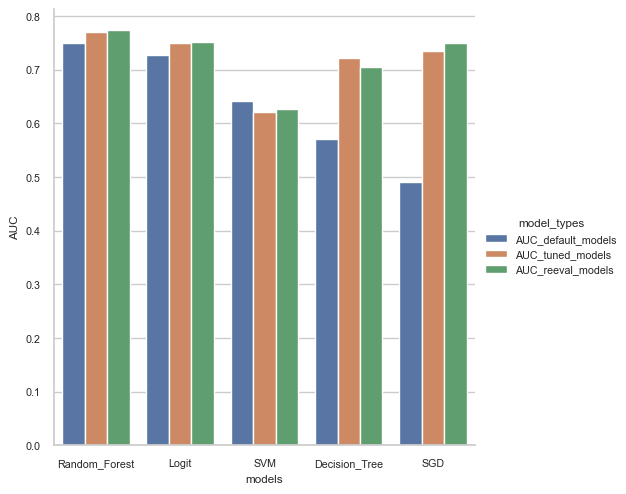

In [104]:
combined_results_df_reshaped = pd.melt(combined_results_df_1.reset_index().rename(columns = {'index':'models'}), 
                                       id_vars='models', 
                                       var_name='model_types',
                                       value_name='AUC')
sns.catplot(data=combined_results_df_reshaped, x='models', y='AUC', hue='model_types', kind='bar')
plt.show()

In [105]:
# The best model after feature selection is Random Forest

### Re-tune the models with refined dataset

In [106]:
res_tab_retuned = {}

#### Logistic Regression

In [107]:
# 1. model_name
model_name = 'Logit'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), 
                         LogisticRegression(random_state=5)
                        )
# 3. Create the parameter grid
param_grid = [{
    'logisticregression__penalty': ['l2', 'l1', 'elasticnet', None],
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
    'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'logisticregression__tol' : [1e-3, 1e-4]
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train[rfe_feature], y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_retuned[model_name] = auc_res

GS_best_param:  {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'logisticregression__tol': 0.001}
AUC:  0.75117


#### Decision Tree

In [108]:
# 1. model_name
model_name = 'Decision_Tree'

# 2. Determine model
scal = StandardScaler()
method = DecisionTreeClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_leaf_nodes': list(range(2, 50, 2)),
    'decisiontreeclassifier__min_samples_split': [2, 3, 5, 10],
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train[rfe_feature], y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_retuned[model_name] = auc_res

GS_best_param:  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_leaf_nodes': 8, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__splitter': 'random'}
AUC:  0.69462


#### Random Forest

In [109]:
# 1. model_name
model_name = 'Random_Forest'

# 2. Determine model
scal = StandardScaler()
method = RandomForestClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'randomforestclassifier__max_depth': range(2, 10, 2),
    'randomforestclassifier__max_features':[2, 3, 4, 7, 10, None],
    'randomforestclassifier__n_estimators':[100, 500, 1000],
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train[rfe_feature], y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_retuned[model_name] = auc_res

GS_best_param:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 7, 'randomforestclassifier__n_estimators': 100}
AUC:  0.76725


#### SGD

In [110]:
# 1. model_name
model_name = 'SGD'

# 2. Determine model
scal = StandardScaler()
method = SGDClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'sgdclassifier__alpha':[0.0001, 0.001, 0.01, 0.1],
    'sgdclassifier__loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet', None],
    'sgdclassifier__tol' : [0.001, 0.0001]
    #'sgdclassifier__max_iter':[1000, 10000, 100000]
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train[rfe_feature], y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_retuned[model_name] = auc_res

GS_best_param:  {'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'modified_huber', 'sgdclassifier__penalty': 'l2', 'sgdclassifier__tol': 0.0001}
AUC:  0.74538


#### SVM

In [111]:
# 1. model_name
model_name = 'SVM'

# 2. Determine model
scal = StandardScaler()
method = SVC(random_state=5, probability = True)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'svc__C':[0.1, 1, 10, 100, 1000],
    'svc__kernel': ['poly', 'rbf', 'sigmoid'],
    'svc__degree': [3, 4, 5],
    'svc__gamma':[0.1, 0.01, 0.001, 0.0001],
    'svc__tol': [1e-3, 1e-4]
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=-1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train[rfe_feature], y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab_retuned[model_name] = auc_res

GS_best_param:  {'svc__C': 100, 'svc__degree': 3, 'svc__gamma': 0.0001, 'svc__kernel': 'sigmoid', 'svc__tol': 0.001}
AUC:  0.68128


#### Result Table

In [112]:
res_tab_retuned_df = (pd.DataFrame.from_dict(res_tab_retuned, orient='index')
                     .rename(columns = {0:'AUC_retuned_models'})
                     .sort_values('AUC_retuned_models', ascending=False)
)
combined_results_df_2 = pd.concat((combined_results_df_1, res_tab_retuned_df), axis=1)
combined_results_df_2

,AUC_default_models,AUC_tuned_models,AUC_reeval_models,AUC_retuned_models
Random_Forest,0.74953,0.77037,0.77379,0.76725
Logit,0.72764,0.74942,0.75117,0.75117
SVM,0.64079,0.62076,0.62601,0.68128
Decision_Tree,0.57150,0.72186,0.70568,0.69462
SGD,0.49032,0.73477,0.74963,0.74538


#### Default vs. Tuned vs. Re-evaluate vs. Re-tuned Models

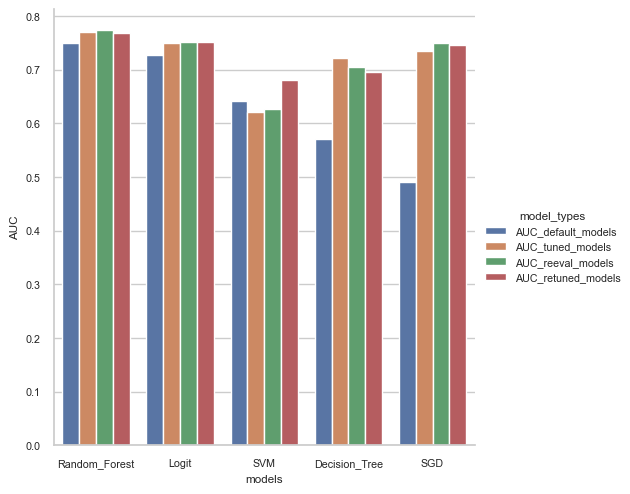

In [113]:
combined_results_df_reshaped = pd.melt(combined_results_df_2.reset_index().rename(columns = {'index':'models'}), id_vars='models', var_name='model_types', value_name='AUC')
sns.catplot(data=combined_results_df_reshaped, x='models', y='AUC', hue='model_types', kind='bar')
plt.show()

In [114]:
# The best model after feature selection and fine tuning is Random Forest

In [115]:
# Fit best model
# 1. Fit model
model = RandomForestClassifier(random_state=5,
                               criterion='gini',
                               max_depth=4,
                               max_features=7,
                               n_estimators = 100
                              )
model.fit(X_train[rfe_feature],y_train)

# 2. Prediction
prediction_prob = model.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)
auc_def = round(auc(fpr, tpr),5)
print('AUC: ', auc_def)

# 3. Prediction + threshold
threshold = 0.16
prediction = np.where(prediction_prob < threshold, 0, 1)
print('confusion_matrix: \n', confusion_matrix(y_test, prediction))

AUC:  0.76718
confusion_matrix: 
 [[386  68]
 [ 33  30]]


#### Threshold analysis

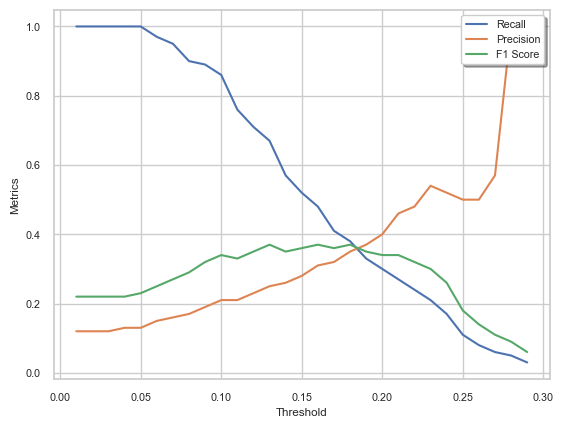

In [116]:
# 1. table with recall, precision, f1 score
rec_prec_threshold = pd.DataFrame(
    {'threshold':np.arange(0.01, 0.3, 0.01),
     'Recall':np.nan,
     'Precision': np.nan,
     'F1_score': np.nan
    } )

# 2. Main calculation
for i in range(len(rec_prec_threshold)):
    prediction = np.where(prediction_prob < rec_prec_threshold['threshold'][i], 0, 1)
    rec_prec_threshold['Recall'][i] = round(recall_score(y_pred=prediction, y_true=y_test),2)
    rec_prec_threshold['Precision'][i] = round(precision_score(y_pred=prediction, y_true=y_test),2)
    rec_prec_threshold['F1_score'][i] = round(f1_score(y_pred=prediction, y_true=y_test), 2)

# 3. Plot
x = rec_prec_threshold.threshold
y  = rec_prec_threshold.Recall
z = rec_prec_threshold.Precision
w = rec_prec_threshold.F1_score
plt.plot(x, y)
plt.plot(x, z)
plt.plot(x, w)
plt.legend(['Recall','Precision', 'F1 Score'], shadow = True, loc = 1)
plt.xlabel('Threshold')
plt.ylabel('Metrics');